# Time Series - Active Users 

## Project problem

A web-based application, is used by University's staff members, students and  agencies. At the moment there we keep track on How many active users are connected every month, but there is no forecasting model in place to predict active users in the following weeks. 

**Goal:** The intention of this notebook is to, using time series, create a model that can predict the active users in the following week.

**Impact:** Since the web application is deployed in the cloud, being able to predict active users, could have an impact in how effectively cloud services are provisioned and adjusted to the demand. It could potentially save some money for the company. 

**Hypothesis:** Based on University placements created, a seasonality component and the number of active users in the previous period, we could predict a higher or lower number of active users.

## Dataset

The dataset is a set of **IIS logs** from a client in Canberra **from 2017-12-07 to 2018-10-10**.

Variable | Description | type of variable 
---|---|---
 date          | Date of the event logged|continuous
 time          | Time of the event logged|continuous
 server-ip     | IP of the server|categorical
 cs-uri-query  | Part of the URL access by the client|categorical
 server-port   | Server port used for serving the page|categorical
 cs-username   | Client user. High percentage of requests are missing the user|categorical 
 client-ip     | IP of the client|categorical
 cs(User-Agent)| Http response part with information about the browser used and the type of device|categorical
 cs(Referer)   | Http reponse part with the URL accessed |categorical
 sc-status     | Http response status|categorical
 sc-substatus  | Http response sub-status|categorical
 time-taken(ms)| time taken in ms, to repond|continuous
 client-city   | City from which the client connected. Derived from the IP|categorical
 client-country| Country from which the client.Derived from the IP |categorical
 client-device | Type of deviced used to access the website by the client (Desktop or Mobile). |categorical
 client-browser| Browser used to access the website by the client. Derived from cs(User-Agent)|categorical
 client-webPage| Web page accessed by the client, Derived from cs(User-Agent)|categorical
 
 **Need to include Placements with students, placement with no students , agreggate per week - also include data related to users if possible, to predict based on type of user, agency, staff, student**

## Domain Knowledge

This is a new area for me, as I have not being actively involved in the development of this product. But when asking around other collegues from work, the conclusion was that as of now, there is no existing process to forecast active users.

There are already tools in the market like google analytics , that will give you insights based on the IIS logs, but I have not seen a tool that out from the box would provide a forecast on active users from the IIS logs.

## Project concerns
**Risks:** 

1) cs-username is missing in a lot of the observations. It might not be good enough to identify what type of user is connection to the website (staff, agency, student). If that is the case, we will just forecast active users as a whole.

2) The features and the model having a very low accuracy, below 60%. 


## Outcomes
For the project to be a success , the prediction accuraty should be at least 60%. If the project fail, I will try other features or timeseries models , with the goal to improve the accuracy to at least 60%.

## EDA

For the EDA, since we have one file for each day, the intention is to load all the files into a dataframe, enhance the data and aggregate it per week.To keep the notebook as tidy as possible, most logic to automate this process has been moved to a python class called **myLogReader.py**.

Below is a summary of the automated steps:

- List every log file in the local folder
- For each file:
    - Load the file in a df
    - Enhance df, deriving city, country, device type, browser used, weekday, etc...
    - **Default NaN** values for city, user name, webpage to **Unknown**
    - For every week (7 log files) loaded, aggregate the data and calculate number of distinct connections, total number of connections, reponse time taken (ms), number of distinct user names, etc...
    
![title](../data/img/Aggregated_data.JPG)


#### Load python libraries

In [25]:
import pandas as pd
import statsmodels.api as sm
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import geoip2.database
import myLogReader as mlr
import re
import os
import sys
import datetime as dt
from pandas.tools.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.metrics import mean_absolute_error

%matplotlib inline

#### Load and transform log files into a data frame

In [ ]:
logsPath = '../data/logs'
geoLiteIPDBPath = '../data/GeoLite2-City_20181009/GeoLite2-City.mmdb'

#Create a myLogReader object
myLogReader = mlr.log()
#Open Reader
myLogReader.openReader(geoLiteIPDBPath)

In [ ]:
for i in range(2,4):
    print ('AggregatedData_week_%d.csv' % i)
    df =  myLogReader.readLogs(logsPath,7)
    df.to_csv('../data/AggregatedData_week_%d.csv' % i)

In [ ]:
#Close Reader
myLogReader.closeReader()

In [ ]:
df.head()

#### Load PlacementSummary and Logs Data aggregated per week

In [13]:
log_aggregated_per_week_df = pd.read_csv('../data/LogsAggregatedData_per_week.csv')
log_aggregated_per_week_df.set_index('calendar-year-week',inplace=True)

In [14]:
log_aggregated_per_week_df.head()

,client-ip-unique-count,cs-username-unique-count,client-connections-count,time-taken(ms)-sum,Chrome-count,Firefox-count,Other-count,Safari-count,Desktop-count,Mobile-count,Season,Month
calendar-year-week,,,,,,,,,,,,
2017-50,925,415,89497,52520170,38500,7784,27741,15472,80440,9057,WINTER,December
2017-51,866,386,81378,44703569,39664,6585,21274,13855,72925,8453,WINTER,December
2017-52,475,179,30843,14199684,9978,553,14279,6033,27735,3108,WINTER,December
2018-01,769,354,71528,42663674,31666,8049,19512,12301,64710,6818,WINTER,January
2018-02,920,441,90093,63904084,38238,6166,23249,22440,79099,10994,WINTER,January


In [4]:
placement_summary_df = pd.read_csv('../data/PlacementSummary.csv')
placement_summary_df.set_index('YearWeek',inplace=True)

In [5]:
placement_summary_df.head()

,PlacementCount,PlacementCompletedCount,PlacementAllocatedInProgressCount,PlacementAllocatedCount,PlacementNotAllocatedCount
YearWeek,,,,,
2017-50,246,48,234,238,8
2017-51,198,77,196,197,1
2017-52,116,3,115,116,0
2017-53,113,17,96,113,0
2018-01,113,4,111,113,0


##### JOIN Log data with Placement data

In [15]:
log_and_placements_aggregated_per_week_df = log_aggregated_per_week_df.join(placement_summary_df)
log_and_placements_aggregated_per_week_df.head()

,client-ip-unique-count,cs-username-unique-count,client-connections-count,time-taken(ms)-sum,Chrome-count,Firefox-count,Other-count,Safari-count,Desktop-count,Mobile-count,Season,Month,PlacementCount,PlacementCompletedCount,PlacementAllocatedInProgressCount,PlacementAllocatedCount,PlacementNotAllocatedCount
calendar-year-week,,,,,,,,,,,,,,,,,
2017-50,925,415,89497,52520170,38500,7784,27741,15472,80440,9057,WINTER,December,246,48,234,238,8
2017-51,866,386,81378,44703569,39664,6585,21274,13855,72925,8453,WINTER,December,198,77,196,197,1
2017-52,475,179,30843,14199684,9978,553,14279,6033,27735,3108,WINTER,December,116,3,115,116,0
2018-01,769,354,71528,42663674,31666,8049,19512,12301,64710,6818,WINTER,January,113,4,111,113,0
2018-02,920,441,90093,63904084,38238,6166,23249,22440,79099,10994,WINTER,January,159,7,159,159,0


In [16]:
log_and_placements_aggregated_per_week_df.isna().sum()

client-ip-unique-count               0
cs-username-unique-count             0
client-connections-count             0
time-taken(ms)-sum                   0
Chrome-count                         0
Firefox-count                        0
Other-count                          0
Safari-count                         0
Desktop-count                        0
Mobile-count                         0
Season                               0
Month                                0
PlacementCount                       0
PlacementCompletedCount              0
PlacementAllocatedInProgressCount    0
PlacementAllocatedCount              0
PlacementNotAllocatedCount           0
dtype: int64

In [17]:
log_and_placements_aggregated_per_week_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 43 entries, 2017-50 to 2018-40
Data columns (total 17 columns):
client-ip-unique-count               43 non-null int64
cs-username-unique-count             43 non-null int64
client-connections-count             43 non-null int64
time-taken(ms)-sum                   43 non-null int64
Chrome-count                         43 non-null int64
Firefox-count                        43 non-null int64
Other-count                          43 non-null int64
Safari-count                         43 non-null int64
Desktop-count                        43 non-null int64
Mobile-count                         43 non-null int64
Season                               43 non-null object
Month                                43 non-null object
PlacementCount                       43 non-null int64
PlacementCompletedCount              43 non-null int64
PlacementAllocatedInProgressCount    43 non-null int64
PlacementAllocatedCount              43 non-null int64
Placement

Current size: [22, 7]


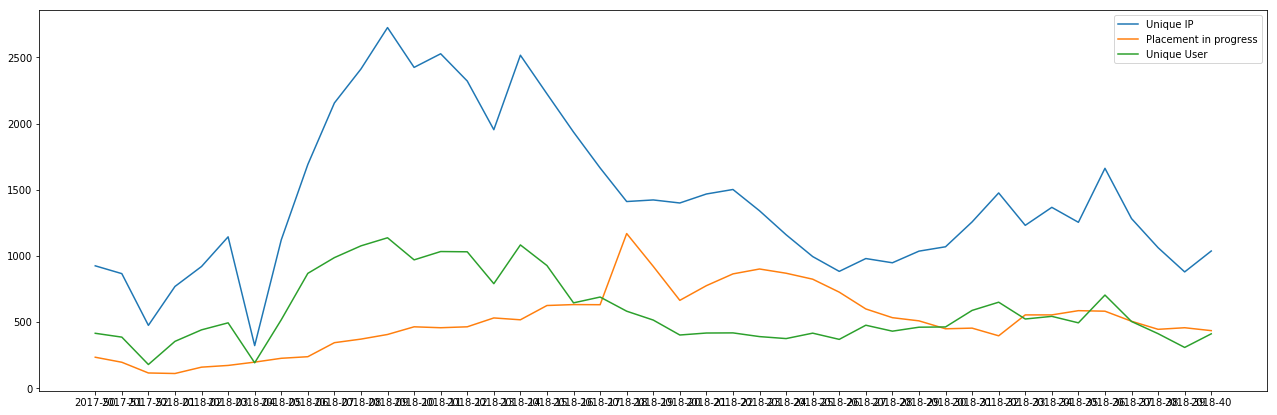

In [19]:
fig_size= plt.rcParams["figure.figsize"]

# Set figure width to 12 and height to 9
fig_size[0] = 22
fig_size[1] = 7
plt.rcParams["figure.figsize"] = fig_size

print ("Current size:",fig_size)

plt.plot(log_and_placements_aggregated_per_week_df.index,log_and_placements_aggregated_per_week_df['client-ip-unique-count'],label="Unique IP")
plt.plot(log_and_placements_aggregated_per_week_df.index,log_and_placements_aggregated_per_week_df['PlacementAllocatedInProgressCount'],label="Placement in progress")
plt.plot(log_and_placements_aggregated_per_week_df.index,log_and_placements_aggregated_per_week_df['cs-username-unique-count'],label="Unique User")
plt.legend()

In [10]:
log_and_placements_aggregated_per_week_df.columns

Index(['client-ip-unique-count', 'cs-username-unique-count',
       'client-connections-count', 'time-taken(ms)-sum', 'Chrome-count',
       'Firefox-count', 'Other-count', 'Safari-count', 'Desktop-count',
       'Mobile-count', 'PlacementCount', 'PlacementCompletedCount',
       'PlacementAllocatedInProgressCount', 'PlacementAllocatedCount',
       'PlacementNotAllocatedCount'],
      dtype='object')

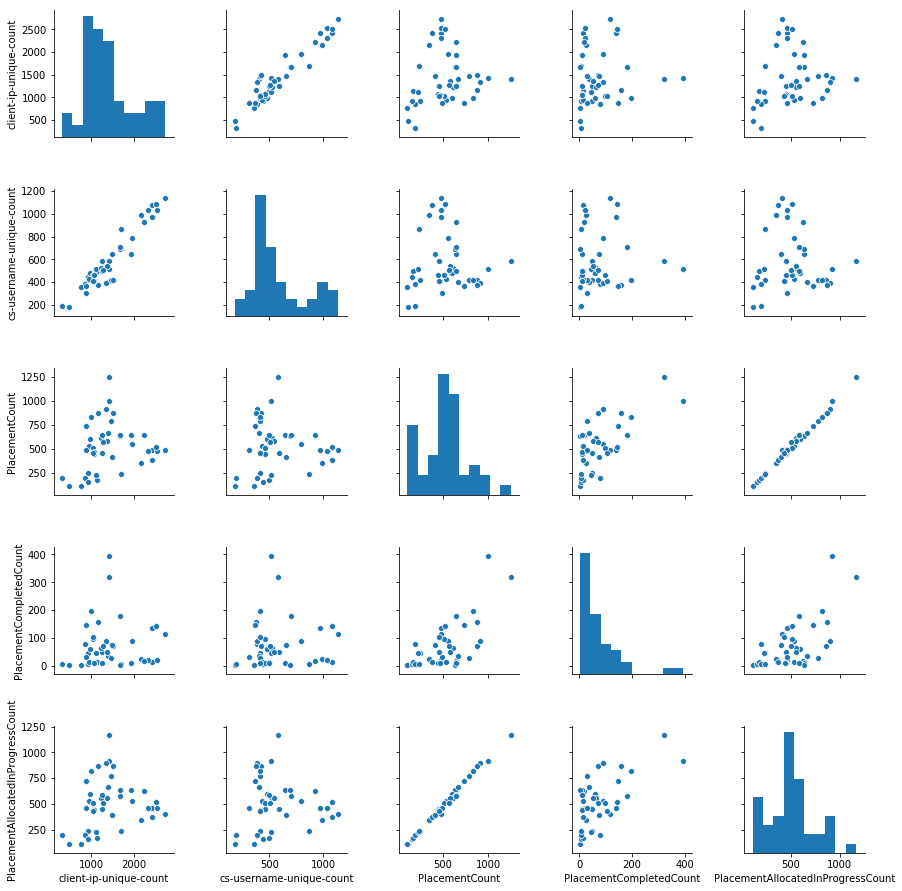

In [20]:
sns.pairplot(data=log_and_placements_aggregated_per_week_df
             ,vars=['client-ip-unique-count','cs-username-unique-count',
                    'PlacementCount', 'PlacementCompletedCount',
                    'PlacementAllocatedInProgressCount'])

#### Autocorrelation

In [23]:
df_train = log_and_placements_aggregated_per_week_df.loc[:"2018-37",['client-ip-unique-count']]
df_test= log_and_placements_aggregated_per_week_df.loc["2018-38":,['client-ip-unique-count']]

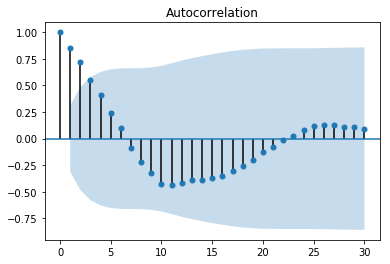

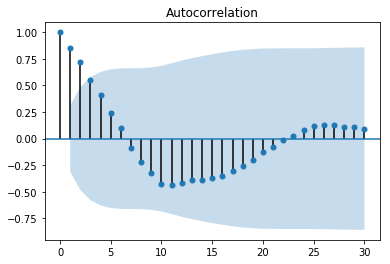

In [26]:
plot_acf(df_train,lags=30)

In [27]:
model = sm.tsa.ARIMA(df_train,(1,0,0)).fit()

predictions = model.predict('2018-38','2018-40',dynamic=True)

C:\Users\ioltra\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\ioltra\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\signal\signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
C:\Users\ioltra\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\signal\signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a

KeyError: 'The `start` argument could not be matched to a location related to the index of the data.'